# EXP01-v2: 구조 기반 청킹 & 메타데이터 최적화

**목표**: V1 실험(EXP01~03)에서 도달한 Context Recall ~0.77 천장을 돌파하기 위해,
RFP 문서의 구조적 특성을 활용한 3가지 개선축을 **Full Factorial Design (2³ = 8 조합)**으로 실험합니다.

**고정 변수** (EXP01~02 최적값):
- 텍스트 추출: `layout=True`
- Hybrid Search Alpha: `0.3` (BM25 70% + Vector 30%)
- Top-K: `15`

**실험 변수**:

| 축 | OFF (0) | ON (1) |
|---|---|---|
| **S** (Structure) | RecursiveCharacterTextSplitter 500자 | 목차/헤딩 기반 섹션 분할 |
| **T** (Table) | 텍스트만 인덱싱 | 표를 Markdown으로 변환하여 추가 인덱싱 |
| **M** (Metadata) | 기본 메타데이터 | 페이지 매핑 + 섹션 컨텍스트 prefix |

## 1. V1 실험 회고 & 문제 인식

### V1 실험 결과 요약

| 실험 | 최적 설정 | Context Recall | 주요 발견 |
|------|-----------|---------------|-----------|
| **EXP01** (청킹) | chunk=500, layout | 0.7333 | 작은 청크가 유리, layout이 text보다 우수 |
| **EXP02** (검색) | alpha=0.3, top_k=15 | 0.7667 | BM25 비중 높을수록 유리 (한국어 키워드 매칭) |
| **EXP03** (프롬프트) | zero_shot_ko | Faithfulness 0.96 | 프롬프트 변경으로 Recall은 미개선 (0.70~0.77) |

### 문제 진단

**Context Recall이 ~0.77에서 정체** → 검색이 필요한 정보의 약 23%를 찾지 못함

근본 원인 분석:
1. **구조 무시 청킹**: `RecursiveCharacterTextSplitter`는 500자 단위로 기계적 분할 → 섹션 경계를 무시하여 의미 단위 파괴
2. **표 데이터 미활용**: `extract_tables()`로 표를 별도 추출하지만 검색 인덱스에 미포함 → 표 기반 질문 검색 실패
3. **빈약한 메타데이터**: `page_no=1` 하드코딩, 섹션 정보 없음 → 임베딩에 문맥 정보 부재
4. **RFP 문서 특성 무시**: 대부분의 RFP는 목차, 번호체계 등 명확한 구조를 가짐 → 이를 활용하지 않음

## 2. V2 실험 설계

### 개선 축 상세

#### 축 1: Structure-aware Chunking (S)
- 목차/헤딩 패턴 탐지: `1.`, `1.1`, `가.`, `제N장` 등
- 헤딩 기반 1차 분할 (섹션 단위) → 큰 섹션만 RecursiveCharacterTextSplitter로 2차 분할
- 의미 단위 보존으로 cross-section 오염 방지

#### 축 2: Table Integration (T)
- pdfplumber 테이블을 Markdown 형식으로 변환
- 텍스트 청크와 함께 별도 테이블 청크로 인덱싱
- 표 기반 질문 (배점, 일정, 자격요건 등) 검색 강화

#### 축 3: Metadata Enrichment (M)
- `page_map` 활용한 정확한 페이지 번호 매핑 (기존 하드코딩 수정)
- 섹션 제목을 청크 텍스트 앞에 prefix로 추가 → 임베딩 품질 향상
- 예: `[섹션: 3.2 평가기준] 본문 텍스트...`

### 실험 매트릭스 (Full Factorial Design)

| # | Config | S | T | M | 설명 |
|---|--------|---|---|---|------|
| 1 | baseline | - | - | - | V1 최적 설정 (대조군) |
| 2 | S | O | - | - | 구조 기반 청킹만 |
| 3 | T | - | O | - | 표 통합만 |
| 4 | M | - | - | O | 메타데이터 강화만 |
| 5 | S+T | O | O | - | 구조 + 표 |
| 6 | S+M | O | - | O | 구조 + 메타데이터 |
| 7 | T+M | - | O | O | 표 + 메타데이터 |
| 8 | S+T+M | O | O | O | 전체 적용 |

### 평가 전략
- **Phase 1** (빠른 스크리닝): Keyword Hit Rate (LLM-free) → 전체 8개 설정
- **Phase 2** (정밀 평가): RAGAS Context Recall + Precision → 상위 설정만

In [4]:
# ============================================================
# 3. Setup
# ============================================================
import os, re, json, time, warnings, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdfplumber
import chromadb
from typing import List, Dict, Tuple
from datetime import datetime

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_community.retrievers import BM25Retriever
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 고정 설정 (EXP01~02 최적값)
ALPHA = 0.3
TOP_K = 15
CHUNK_SIZE = 500
CHUNK_OVERLAP = 50
EMBED_MODEL = "text-embedding-3-small"
DEBUG_FIND_FAIL = False  # True면 find 실패 케이스를 상세 로깅

embeddings = OpenAIEmbeddings(model=EMBED_MODEL)
chroma_client = chromadb.EphemeralClient()  # In-memory → 디스크 누적 방지

print("Setup complete")
print(f"  Fixed: alpha={ALPHA}, top_k={TOP_K}, chunk_size={CHUNK_SIZE}")
print(f"  Chroma: EphemeralClient (in-memory)")
print(f"  Debug find failures: {DEBUG_FIND_FAIL}")


Setup complete
  Fixed: alpha=0.3, top_k=15, chunk_size=500
  Chroma: EphemeralClient (in-memory)
  Debug find failures: False


In [5]:
# ============================================================
# 4. 데이터 로드 & PDF 1회 파싱
# ============================================================
SAMPLE_PDF = "../data/raw/files/고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf"
GOLDEN_CSV = "../data/experiments/golden_testset.csv"

golden_df = pd.read_csv(GOLDEN_CSV)
print(f"Golden Testset: {len(golden_df)} cases")
print(f"  Categories: {golden_df['category'].nunique()}")
print(f"  Difficulty: {golden_df['difficulty'].value_counts().to_dict()}")

# V1 최적 결과/고정 파라미터 로드 (하드코딩 방지)
v1_recall = 0.7667  # default fallback
try:
    with open('../data/experiments/exp02_report.json', 'r', encoding='utf-8') as f:
        _exp02 = json.load(f)

    best_cfg = _exp02.get('best_config', {})
    v1_recall = best_cfg.get('context_recall', 0.7667)

    # EXP01-v2 고정값은 EXP02 best config를 사용 (공정 비교 보장)
    ALPHA = float(best_cfg.get('alpha', ALPHA))
    TOP_K = int(best_cfg.get('top_k', TOP_K))

    print(f"\nV1 Baseline (from exp02_report.json): Context Recall = {v1_recall:.4f}")
    print(f"Fixed retrieval params synced from EXP02 best: alpha={ALPHA}, top_k={TOP_K}")
except FileNotFoundError:
    print(f"\nV1 Baseline (default fallback): Context Recall = {v1_recall:.4f}")
    print(f"Fixed retrieval params fallback: alpha={ALPHA}, top_k={TOP_K}")

# PDF 파싱 (1회) - 전체 실험에서 재사용
from bidflow.parsing.preprocessor import TextPreprocessor
preprocessor = TextPreprocessor()

print(f"\nParsing: {os.path.basename(SAMPLE_PDF)}...")
t0 = time.time()

with pdfplumber.open(SAMPLE_PDF) as pdf:
    page_texts = []    # [(page_no, normalized_text), ...]
    page_tables = []   # [(page_no, table_idx, table_data), ...]
    
    for i, page in enumerate(pdf.pages):
        raw_text = page.extract_text(layout=True) or ""
        norm_text = preprocessor.normalize(raw_text)
        page_texts.append((i + 1, norm_text))
        
        tables = page.extract_tables()
        if tables:
            for j, table in enumerate(tables):
                if table and any(any(cell for cell in row) for row in table):
                    page_tables.append((i + 1, j, table))
    
    # 전체 텍스트 + 페이지 경계 맵 구축
    full_text = ""
    page_map = []  # [(start_idx, end_idx, page_no), ...]
    
    for page_no, text in page_texts:
        start = len(full_text)
        full_text += text + "\n\n"
        end = len(full_text)
        page_map.append((start, end, page_no))

# 라인별 오프셋 사전 계산 (헤딩/청크 위치 매핑의 정확성 보장)
_lines = full_text.split('\n')
line_offsets = [0]
for _line in _lines:
    line_offsets.append(line_offsets[-1] + len(_line) + 1)  # +1 for '\n'

parse_time = time.time() - t0
print(f"Parsed in {parse_time:.1f}s")
print(f"  Pages: {len(page_texts)}, Total chars: {len(full_text):,}")
print(f"  Tables extracted: {len(page_tables)}")
print(f"  Lines: {len(_lines)}, Line offsets computed")


Golden Testset: 30 cases
  Categories: 14
  Difficulty: {'easy': 15, 'medium': 12, 'hard': 3}

V1 Baseline (from exp02_report.json): Context Recall = 0.7667
Fixed retrieval params synced from EXP02 best: alpha=0.5, top_k=15

Parsing: 고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf...
Parsed in 26.2s
  Pages: 297, Total chars: 218,016
  Tables extracted: 420
  Lines: 15073, Line offsets computed


## 3. 개선 구현

In [6]:
# ============================================================
# 3.1 Structure-aware Chunking (S)
# ============================================================

# 한국어 RFP 문서 헤딩 패턴
HEADING_PATTERNS = [
    (re.compile(r'^\s{0,10}제\s*\d+\s*[장절]\s*.{2,}'), 1),
    (re.compile(r'^\s{0,10}제\s*\d+\s*조[\s(]'), 2),
    (re.compile(r'^\s{0,10}\d{1,2}\.\s+\S.{2,}'), 1),
    (re.compile(r'^\s{0,10}\d{1,2}\.\d{1,2}\.?\s+\S.{2,}'), 2),
    (re.compile(r'^\s{0,10}\d{1,2}\.\d{1,2}\.\d{1,2}\.?\s+\S.{2,}'), 3),
    (re.compile(r'^\s{0,10}[가나다라마바사아자차카타파하]\.\s+\S.{2,}'), 2),
    (re.compile(r'^\s{0,10}(?:\d{1,2}|[가나다라마바사아자차카타파하])\)\s+\S.{2,}'), 3),
    (re.compile(r'^\s{0,10}[\[【]\s*(?:별첨|붙임|부록)\s*\d*'), 1),
]

def detect_headings(text: str, max_len: int = 80) -> List[Dict]:
    """한국어 RFP 텍스트에서 섹션 헤딩을 탐지합니다."""
    headings = []
    lines = text.split('\n')
    
    for line_no, line in enumerate(lines):
        stripped = line.strip()
        if len(stripped) < 3 or len(stripped) > max_len:
            continue
        for pattern, level in HEADING_PATTERNS:
            if pattern.match(stripped):
                headings.append({
                    'line_no': line_no,
                    'text': stripped,
                    'level': level,
                })
                break
    return headings


def structure_aware_split(
    text: str, line_offsets: list,
    chunk_size: int = 500, chunk_overlap: int = 50
) -> List[Tuple[str, str, int]]:
    """
    헤딩 기반 섹션 분할 + 큰 섹션 2차 분할.
    line_offsets를 사용하여 정확한 char offset을 반환합니다.
    
    Returns: [(section_title, chunk_text, char_offset), ...]
    """
    lines = text.split('\n')
    hdgs = detect_headings(text)
    
    fallback = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ".", " ", ""]
    )
    
    if len(hdgs) < 3:
        print(f"    [S] Headings {len(hdgs)}개 → Fallback to standard split")
        plain_chunks = fallback.split_text(text)
        result = []
        search_from = 0
        for c in plain_chunks:
            idx = text.find(c, search_from)
            if idx < 0:
                idx = text.find(c[:80], search_from)
            if idx < 0:
                log_find_failure("structure_fallback", text, c, search_from)
            result.append(("", c, max(idx, 0)))
            if idx >= 0:
                search_from = idx + 1
        return result
    
    print(f"    [S] Headings {len(hdgs)}개 detected")
    
    # 섹션 구축
    sections = []
    
    # 첫 헤딩 이전 텍스트
    if hdgs[0]['line_no'] > 0:
        pre = '\n'.join(lines[:hdgs[0]['line_no']]).strip()
        if len(pre) > 20:
            sections.append(('문서 서두', pre, 0))
    
    # 헤딩 간 섹션
    for i, h in enumerate(hdgs):
        end_line = hdgs[i+1]['line_no'] if i+1 < len(hdgs) else len(lines)
        title = h['text'].strip()
        body_start_line = h['line_no'] + 1
        body = '\n'.join(lines[body_start_line:end_line]).strip()
        
        # line_offsets로 정확한 char offset 계산 (find() 대신)
        char_offset = line_offsets[body_start_line] if body_start_line < len(line_offsets) else line_offsets[h['line_no']]
        
        if body and len(body) > 10:
            sections.append((title, body, char_offset))
    
    # 큰 섹션 2차 분할
    result = []
    for title, body, base_offset in sections:
        if len(body) <= chunk_size * 1.2:
            result.append((title, body, base_offset))
        else:
            sub_chunks = fallback.split_text(body)
            search_from = 0
            for sub in sub_chunks:
                sub_idx = body.find(sub, search_from)
                if sub_idx < 0:
                    sub_idx = body.find(sub[:80], search_from)
                if sub_idx < 0:
                    log_find_failure(f"section_subsplit:{title[:30]}", body, sub, search_from)
                actual_offset = base_offset + max(sub_idx, 0)
                result.append((title, sub, actual_offset))
                if sub_idx >= 0:
                    search_from = sub_idx + 1
    
    return result


# 탐지 테스트
headings = detect_headings(full_text)
print(f"=== Heading Detection Test ===")
print(f"Total headings: {len(headings)}")
print(f"\nSample (first 15):")
for h in headings[:15]:
    indent = '  ' * h['level']
    print(f"  L{h['level']} | {indent}{h['text'][:60]}")

=== Heading Detection Test ===
Total headings: 294

Sample (first 15):
  L1 |   1. 사업개요
  L2 |     가. 사업명: 고려대학교 차세대 포털·학사 정보시스템 구축 사업
  L2 |     나. 사업기간: 계약일로부터 24개월 이내
  L2 |     다. 무상유지보수기간 : 사업종료일로부터 12개월
  L2 |     라. 사업예산 : 11,270,000,000원 (V.A.T 포함, 3년 분할 지급)
  L2 |     마. 입찰 및 계약 방법: 제한 경쟁 입찰(협상에 의한 계약)
  L2 |     바. 본 사업은 3개년에 걸친 다년 사업으로, 사업 수행에 따른 대가도 3개년에 걸쳐
  L1 |   2. 추진 배경 및 필요성
  L2 |     가. (교육 환경의 급격한 변화 대응) 학령인구 감소, 코로나 팬데믹으로 인한 교육환
  L2 |     나. (분산된 시스템 및 데이터의 통합) 급변하는 교육환경 속에서 정보화 요구사항은
  L2 |     다. (데이터 기반 대학경영 지원 개선) 분절된 정보시스템 간 정보연계 미흡 및 정보
  L2 |     라. (사용자 정보서비스 접근성 개선) 또한, 교내 구성원의 정보탐색 지원을 위한 포
  L2 |     마. (대학 경쟁력 강화 및 전략목표 달성 지원) 노후화된 시스템의 차세대 구축을 통
  L1 |   3. 사업 범위
  L2 |     가. 응용SW개발


In [7]:
# ============================================================
# 3.2 Table Integration (T) & 3.3 Metadata Helpers (M)
# ============================================================

def table_to_markdown(table_data: list) -> str:
    """pdfplumber 테이블 → Markdown 표 변환"""
    if not table_data or len(table_data) < 1:
        return ""
    max_cols = max(len(row) for row in table_data)
    
    rows = []
    for row in table_data:
        clean = []
        for cell in row:
            c = str(cell).strip().replace('\n', ' ').replace('|', '/') if cell else ""
            clean.append(c if c != "None" else "")
        while len(clean) < max_cols:
            clean.append("")
        rows.append(clean)
    
    if all(all(c == "" for c in row) for row in rows):
        return ""
    
    lines = []
    lines.append("| " + " | ".join(rows[0]) + " |")
    lines.append("| " + " | ".join(["---"] * max_cols) + " |")
    for row in rows[1:]:
        lines.append("| " + " | ".join(row) + " |")
    return "\n".join(lines)


def get_page_for_position(char_idx: int, page_map: list) -> int:
    """문자 위치 → 페이지 번호"""
    if char_idx < 0:
        return 1
    for start, end, page_no in page_map:
        if start <= char_idx < end:
            return page_no
    return 1


def build_heading_positions(headings: list, line_offsets: list) -> List[Tuple[int, str]]:
    """라인 번호 기반으로 헤딩의 char 위치를 계산합니다.
    
    find() 대신 line_offsets를 사용하여 동일 텍스트 중복 시에도 정확한 위치를 보장합니다.
    """
    positions = []
    for h in headings:
        if h['line_no'] < len(line_offsets):
            char_idx = line_offsets[h['line_no']]
            positions.append((char_idx, h['text']))
    return positions


def find_nearest_heading(char_idx: int, heading_positions: list) -> str:
    """주어진 문자 위치 이전의 가장 가까운 헤딩"""
    if char_idx < 0 or not heading_positions:
        return ""
    best = ""
    for pos, text in heading_positions:
        if pos <= char_idx:
            best = text
        else:
            break
    return best


def strip_section_prefix(text: str) -> str:
    """[섹션: ...] prefix를 제거하여 원본 텍스트를 반환합니다.
    
    RAGAS 평가 시 섹션 prefix에 의한 점수 과대평가를 방지하기 위해 사용합니다.
    """
    if text.startswith('[섹션:'):
        nl = text.find('\n')
        if nl >= 0:
            rest = text[nl + 1:]
            # [표] prefix도 있으면 추가 제거
            if rest.startswith('[표]\n'):
                return rest[4:]
            return rest
    if text.startswith('[표]\n'):
        return text[4:]
    return text


def log_find_failure(context: str, haystack: str, needle: str, search_from: int) -> None:
    """find 실패 시 디버깅 정보를 출력합니다."""
    if not DEBUG_FIND_FAIL:
        return
    preview = needle[:80].replace('\n', ' ')
    local = haystack[max(0, search_from - 40):search_from + 120].replace('\n', ' ')
    print(
        f"[find-fail] ctx={context} | search_from={search_from} | "
        f"needle_len={len(needle)} | haystack_len={len(haystack)} | "
        f"needle_preview='{preview}' | around_cursor='{local}'"
    )


# 헤딩 위치 인덱스 구축 (line_offsets 기반 - 정확)
heading_positions = build_heading_positions(headings, line_offsets)
print(f"Heading positions indexed: {len(heading_positions)}")

# 위치 정확성 검증 (샘플)
if heading_positions:
    pos, txt = heading_positions[0]
    actual = full_text[pos:pos+len(txt)]
    print(f"  Verify: offset={pos}, expected='{txt[:40]}', actual='{actual[:40]}'")

# 테이블 변환 테스트
print(f"\nTotal tables: {len(page_tables)}")
if page_tables:
    pg, idx, tbl = page_tables[0]
    md = table_to_markdown(tbl)
    print(f"Sample (p{pg}, table {idx}):")
    print(md[:300] if len(md) > 300 else md)

Heading positions indexed: 294
  Verify: offset=3595, expected='1. 사업개요', actual=' 1. 사업개'

Total tables: 420
Sample (p5, table 0):
|  | 고려대학교 차세대 포털·학사 정보시스템 구축 사업 |  |
| --- | --- | --- |


In [8]:
# ============================================================
# 3.4 통합 청크 빌더
# ============================================================

def build_chunks(
    full_text: str,
    page_tables: list,
    page_map: list,
    headings: list,
    heading_positions: list,
    line_offsets: list,
    use_structure: bool = False,
    use_tables: bool = False,
    use_metadata: bool = False,
    chunk_size: int = 500,
    chunk_overlap: int = 50,
) -> List[Document]:
    """S/T/M 플래그에 따라 LangChain Document 리스트 생성.
    
    M=True일 때 page_content에 [섹션: ...] prefix가 추가됩니다.
    RAGAS 평가 시에는 strip_section_prefix()로 원본 텍스트를 사용하세요.
    """
    
    # --- Step 1: 텍스트 청킹 (char offset 포함) ---
    if use_structure:
        section_chunks = structure_aware_split(full_text, line_offsets, chunk_size, chunk_overlap)
    else:
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size, chunk_overlap=chunk_overlap,
            separators=["\n\n", "\n", ".", " ", ""]
        )
        plain_chunks = splitter.split_text(full_text)
        # 순차 탐색으로 offset 계산 (search_from으로 중복 매칭 방지)
        section_chunks = []
        search_from = 0
        for c in plain_chunks:
            idx = full_text.find(c, search_from)
            if idx < 0:
                idx = full_text.find(c[:80], search_from)
            if idx < 0:
                log_find_failure("plain_split", full_text, c, search_from)
            section_chunks.append(("", c, max(idx, 0)))
            if idx >= 0:
                search_from = idx + 1
    
    # --- Step 2: Document 객체 생성 ---
    documents = []
    for idx, (section_title, text, char_offset) in enumerate(section_chunks):
        if use_metadata:
            # char_offset 기반 페이지 매핑 (find() 대신 정확한 offset 사용)
            page_no = get_page_for_position(char_offset, page_map)
            
            # 섹션 컨텍스트 prefix
            if section_title:
                nearest = section_title
            else:
                nearest = find_nearest_heading(char_offset, heading_positions)
            
            display_text = f"[섹션: {nearest}]\n{text}" if nearest else text
            meta = {
                "chunk_id": f"chunk_{idx}",
                "page_no": page_no,
                "section_title": nearest,
                "content_type": "text",
            }
        else:
            display_text = text
            meta = {"chunk_id": f"chunk_{idx}"}
        
        documents.append(Document(page_content=display_text, metadata=meta))
    
    # --- Step 3: 테이블 청크 추가 ---
    # NOTE: layout=True 텍스트에 이미 표 내용이 포함되어 중복 가능하지만,
    # 별도 Markdown 청크는 구조화된 표현을 제공하여 표 기반 질문 검색을 강화합니다.
    if use_tables:
        t_count = 0
        for pg_no, t_idx, table_data in page_tables:
            md = table_to_markdown(table_data)
            if md and len(md.strip()) > 30:
                if use_metadata:
                    pg_start = 0
                    for s, e, pn in page_map:
                        if pn == pg_no:
                            pg_start = s
                            break
                    sec = find_nearest_heading(pg_start, heading_positions)
                    display_md = f"[섹션: {sec}] [표]\n{md}" if sec else f"[표]\n{md}"
                    meta = {
                        "chunk_id": f"table_p{pg_no}_{t_idx}",
                        "page_no": pg_no,
                        "section_title": sec,
                        "content_type": "table",
                    }
                else:
                    display_md = md
                    meta = {"chunk_id": f"table_p{pg_no}_{t_idx}"}
                
                documents.append(Document(page_content=display_md, metadata=meta))
                t_count += 1
        if t_count > 0:
            print(f"    [T] Table chunks: +{t_count}")
    
    return documents


# 테스트: baseline vs S+T+M
test_base = build_chunks(
    full_text, page_tables, page_map, headings, heading_positions, line_offsets,
    use_structure=False, use_tables=False, use_metadata=False
)
test_full = build_chunks(
    full_text, page_tables, page_map, headings, heading_positions, line_offsets,
    use_structure=True, use_tables=True, use_metadata=True
)
print(f"\nBaseline: {len(test_base)} chunks")
print(f"S+T+M:    {len(test_full)} chunks")
print(f"\n--- Baseline sample ---")
print(test_base[5].page_content[:200])
print(f"\n--- S+T+M sample (with prefix) ---")
print(test_full[5].page_content[:200])
print(f"\n--- S+T+M sample (prefix stripped for RAGAS) ---")
print(strip_section_prefix(test_full[5].page_content)[:200])

    [S] Headings 294개 detected
    [T] Table chunks: +414

Baseline: 591 chunks
S+T+M:    1070 chunks

--- Baseline sample ---
2. 상세 요구사항 ····································································································· 43
 
 V. 제안 일반 사항 ·····································································

--- S+T+M sample (with prefix) ---
[섹션: 문서 서두]
2. 상세 요구사항 ····································································································· 43
 
 V. 제안 일반 사항 ·························································

--- S+T+M sample (prefix stripped for RAGAS) ---
2. 상세 요구사항 ····································································································· 43
 
 V. 제안 일반 사항 ·····································································


In [9]:
# ============================================================
# 4. 실험 프레임워크
# ============================================================

# --- 실험 설정 ---
EXPERIMENT_CONFIGS = [
    {"name": "baseline",  "label": "V1 Baseline",              "S": False, "T": False, "M": False},
    {"name": "S",         "label": "Structure-aware",           "S": True,  "T": False, "M": False},
    {"name": "T",         "label": "Table Integration",         "S": False, "T": True,  "M": False},
    {"name": "M",         "label": "Metadata Enrichment",       "S": False, "T": False, "M": True},
    {"name": "S+T",       "label": "Structure + Table",         "S": True,  "T": True,  "M": False},
    {"name": "S+M",       "label": "Structure + Metadata",      "S": True,  "T": False, "M": True},
    {"name": "T+M",       "label": "Table + Metadata",          "S": False, "T": True,  "M": True},
    {"name": "S+T+M",     "label": "All Combined",              "S": True,  "T": True,  "M": True},
]

# --- 한국어 조사 제거 패턴 (Keyword HR 신뢰도 향상) ---
KO_PARTICLES = re.compile(
    r'(은|는|이|가|을|를|의|에|에서|으로|로|와|과|도|만|까지|부터|보다|처럼|같이|대로|마다)$'
)

def normalize_keyword(token: str) -> str:
    """한국어 토큰에서 조사를 제거하고 정규화합니다."""
    token = token.strip()
    if len(token) <= 2:
        return token
    stripped = KO_PARTICLES.sub('', token)
    return stripped if len(stripped) >= 2 else token


# --- RRF Merge ---
def _doc_key(doc) -> str:
    """RRF 병합용 안정 키를 생성합니다.

    page_content[:200] 기반 키는 서로 다른 청크가 충돌할 수 있으므로,
    metadata chunk_id 우선 + (page_no, content_type, content hash) 조합으로 충돌 가능성을 낮춥니다.
    """
    meta = getattr(doc, 'metadata', {}) or {}
    chunk_id = meta.get('chunk_id')
    if chunk_id:
        return f"chunk:{chunk_id}"

    page_no = meta.get('page_no', 'na')
    ctype = meta.get('content_type', 'text')
    digest = hashlib.sha1(doc.page_content.encode('utf-8')).hexdigest()[:16]
    return f"fallback:{page_no}:{ctype}:{digest}"


def rrf_merge(bm25_docs, vector_docs, bm25_weight=0.7, vector_weight=0.3, k=60, top_k=15):
    """Reciprocal Rank Fusion"""
    scores = {}
    doc_map = {}

    for rank, doc in enumerate(bm25_docs):
        key = _doc_key(doc)
        scores[key] = scores.get(key, 0.0) + bm25_weight * (1 / (rank + k))
        doc_map[key] = doc

    for rank, doc in enumerate(vector_docs):
        key = _doc_key(doc)
        scores[key] = scores.get(key, 0.0) + vector_weight * (1 / (rank + k))
        if key not in doc_map:
            doc_map[key] = doc

    sorted_keys = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)
    return [doc_map[k_] for k_ in sorted_keys[:top_k]]


# --- Keyword Hit Rate (한국어 조사 제거 + 정규화 적용) ---
def keyword_hit_rate(ground_truth: str, retrieved_texts: list) -> float:
    """정답 키워드가 검색 결과에 포함된 비율 (조사 제거 + 정규화)"""
    tokens = re.split(r'[\s,.\-·()（）/\[\]【】:：;；\n]+', str(ground_truth))
    keywords = [normalize_keyword(t) for t in tokens if len(t) >= 2 and not t.isdigit()]
    keywords = [k for k in keywords if len(k) >= 2]
    
    if not keywords:
        return 1.0
    
    combined = ' '.join(retrieved_texts)
    hits = sum(1 for kw in keywords if kw in combined)
    return hits / len(keywords)


# --- 단일 실험 실행 ---
def run_single_experiment(config, golden_df, full_text, page_tables,
                          page_map, headings, heading_positions, line_offsets,
                          embeddings, chroma_client):
    """단일 설정으로 인덱싱 → 검색 → Keyword Hit Rate 측정
    
    검색 결과를 display_text (원본)와 raw_text (prefix 제거) 두 가지로 저장합니다.
    RAGAS 평가 시에는 raw_text를 사용하여 prefix에 의한 점수 과대평가를 방지합니다.
    """
    
    print(f"  Building chunks (S={config['S']}, T={config['T']}, M={config['M']})...")
    t0 = time.time()
    
    docs = build_chunks(
        full_text, page_tables, page_map, headings, heading_positions, line_offsets,
        use_structure=config['S'],
        use_tables=config['T'],
        use_metadata=config['M'],
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
    )
    chunk_time = time.time() - t0
    print(f"    Chunks: {len(docs)} ({chunk_time:.1f}s)")
    
    if not docs:
        return {"error": "No chunks generated"}
    
    # 인덱싱 (EphemeralClient → In-memory, 디스크 누적 방지)
    print(f"  Indexing...")
    t0 = time.time()
    collection_name = f"exp01v2_{config['name'].replace('+', '_')}_{int(time.time())}"
    vector_db = Chroma.from_documents(
        documents=docs, embedding=embeddings,
        collection_name=collection_name,
        client=chroma_client,
    )
    bm25 = BM25Retriever.from_documents(docs, k=TOP_K * 2)
    vector_retriever = vector_db.as_retriever(search_kwargs={"k": TOP_K * 2})
    index_time = time.time() - t0
    print(f"    Indexed ({index_time:.1f}s)")
    
    # 검색 + 평가
    print(f"  Retrieving & evaluating {len(golden_df)} questions...")
    t0 = time.time()
    
    hit_rates = []
    all_retrieved = {}       # question -> [display_texts]
    all_retrieved_raw = {}   # question -> [raw_texts] (prefix 제거, RAGAS용)
    
    for _, row in golden_df.iterrows():
        question = row['question']
        gt = str(row['ground_truth'])
        
        bm25_docs = bm25.invoke(question)
        vec_docs = vector_retriever.invoke(question)
        merged = rrf_merge(bm25_docs, vec_docs,
                          bm25_weight=1-ALPHA, vector_weight=ALPHA,
                          top_k=TOP_K)
        
        retrieved_texts = [d.page_content for d in merged]
        # RAGAS 평가용: 섹션 prefix 제거 → 점수 과대평가 방지
        raw_texts = [strip_section_prefix(d.page_content) for d in merged]
        
        all_retrieved[question] = retrieved_texts
        all_retrieved_raw[question] = raw_texts
        
        # Keyword HR은 display_text로 평가 (prefix가 키워드 매칭에 도움될 수 있음)
        hr = keyword_hit_rate(gt, retrieved_texts)
        hit_rates.append(hr)
    
    retrieval_time = time.time() - t0
    
    # 컬렉션 정리
    try:
        vector_db.delete_collection()
    except Exception:
        pass
    
    avg_hit_rate = np.mean(hit_rates)
    print(f"    Keyword Hit Rate: {avg_hit_rate:.4f} ({retrieval_time:.1f}s)")
    
    return {
        "config": config['name'],
        "label": config['label'],
        "S": config['S'],
        "T": config['T'],
        "M": config['M'],
        "num_chunks": len(docs),
        "keyword_hit_rate": avg_hit_rate,
        "hit_rates_per_q": hit_rates,
        "retrieved": all_retrieved,
        "retrieved_raw": all_retrieved_raw,
        "chunk_time": chunk_time,
        "index_time": index_time,
        "retrieval_time": retrieval_time,
    }

print(f"Framework ready. {len(EXPERIMENT_CONFIGS)} configs to test.")


Framework ready. 8 configs to test.


## 5. Phase 1: 빠른 스크리닝 (Keyword Hit Rate)

LLM 호출 없이 모든 8개 설정을 빠르게 평가합니다.
- **Keyword Hit Rate**: 정답(ground_truth)의 키워드가 검색 결과에 포함된 비율
- LLM-free → 설정당 약 1~2분

In [10]:
# Phase 1 실행
phase1_results = []

for i, config in enumerate(EXPERIMENT_CONFIGS):
    print(f"\n{'='*60}")
    print(f"[{i+1}/{len(EXPERIMENT_CONFIGS)}] {config['label']} ({config['name']})")
    print(f"{'='*60}")
    
    result = run_single_experiment(
        config, golden_df, full_text, page_tables,
        page_map, headings, heading_positions, line_offsets,
        embeddings, chroma_client
    )
    phase1_results.append(result)

print(f"\n\nPhase 1 complete!")


[1/8] V1 Baseline (baseline)
  Building chunks (S=False, T=False, M=False)...
    Chunks: 591 (0.0s)
  Indexing...
    Indexed (2.9s)
  Retrieving & evaluating 30 questions...
    Keyword Hit Rate: 0.8096 (4.3s)

[2/8] Structure-aware (S)
  Building chunks (S=True, T=False, M=False)...
    [S] Headings 294개 detected
    Chunks: 656 (0.0s)
  Indexing...
    Indexed (3.1s)
  Retrieving & evaluating 30 questions...
    Keyword Hit Rate: 0.8089 (3.7s)

[3/8] Table Integration (T)
  Building chunks (S=False, T=True, M=False)...
    [T] Table chunks: +414
    Chunks: 1005 (0.0s)
  Indexing...
    Indexed (5.5s)
  Retrieving & evaluating 30 questions...
    Keyword Hit Rate: 0.7989 (3.7s)

[4/8] Metadata Enrichment (M)
  Building chunks (S=False, T=False, M=True)...
    Chunks: 591 (0.0s)
  Indexing...
    Indexed (3.1s)
  Retrieving & evaluating 30 questions...
    Keyword Hit Rate: 0.8202 (3.7s)

[5/8] Structure + Table (S+T)
  Building chunks (S=True, T=True, M=False)...
    [S] Headings 

=== Phase 1: Keyword Hit Rate Ranking ===
  Config                Label     S     T     M  Chunks  Keyword_HR  Time(s)
     S+M Structure + Metadata  True False  True     656    0.838135 6.734116
     T+M     Table + Metadata False  True  True    1005    0.827118 9.136356
       M  Metadata Enrichment False False  True     591    0.820247 6.749783
baseline          V1 Baseline False False False     591    0.809641 7.223599
       S      Structure-aware  True False False     656    0.808926 6.788025
       T    Table Integration False  True False    1005    0.798889 9.168671
   S+T+M         All Combined  True  True  True    1070    0.797247 9.136432
     S+T    Structure + Table  True  True False    1070    0.764666 9.067041


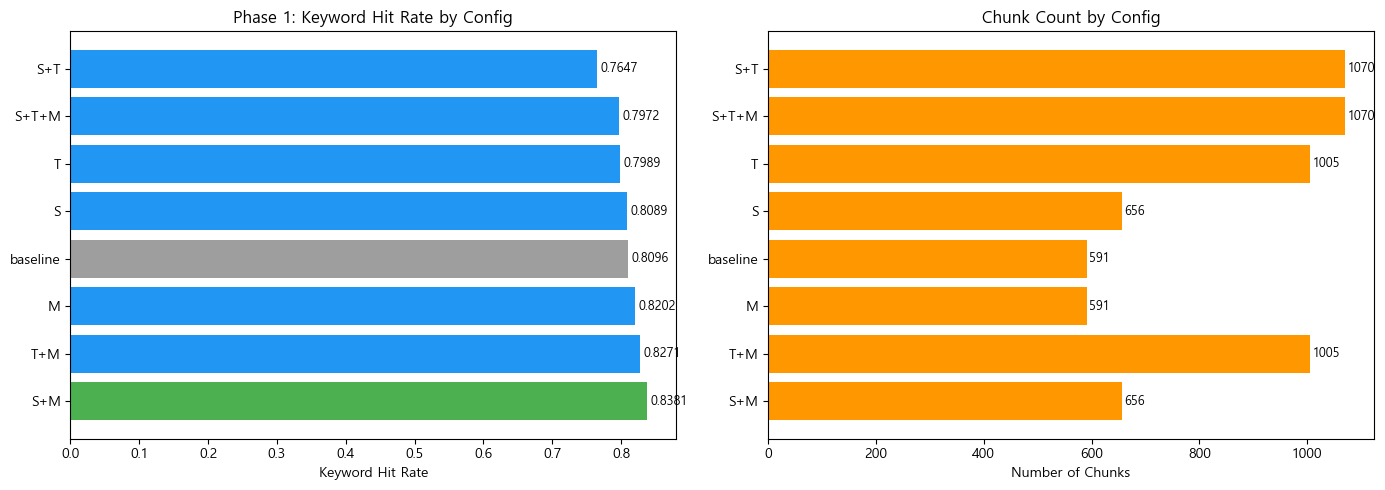


Baseline Keyword HR: 0.8096
Phase 2 candidates: ['S+M', 'T+M', 'M', 'baseline']


In [11]:
# Phase 1 결과 정리 & 시각화
phase1_df = pd.DataFrame([{
    'Config': r['config'],
    'Label': r['label'],
    'S': r['S'],
    'T': r['T'],
    'M': r['M'],
    'Chunks': r['num_chunks'],
    'Keyword_HR': r['keyword_hit_rate'],
    'Time(s)': r['chunk_time'] + r['index_time'] + r['retrieval_time'],
} for r in phase1_results])

phase1_df = phase1_df.sort_values('Keyword_HR', ascending=False).reset_index(drop=True)
print("=== Phase 1: Keyword Hit Rate Ranking ===")
print(phase1_df.to_string(index=False))

# 차트
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Keyword Hit Rate
colors = ['#2196F3' if r['config'] != 'baseline' else '#9E9E9E' for r in phase1_results]
sorted_results = sorted(phase1_results, key=lambda x: x['keyword_hit_rate'], reverse=True)
names = [r['config'] for r in sorted_results]
hrs = [r['keyword_hit_rate'] for r in sorted_results]
bar_colors = ['#4CAF50' if r['config'] == sorted_results[0]['config'] 
              else '#9E9E9E' if r['config'] == 'baseline'
              else '#2196F3' for r in sorted_results]

axes[0].barh(names, hrs, color=bar_colors)
axes[0].set_xlabel('Keyword Hit Rate')
axes[0].set_title('Phase 1: Keyword Hit Rate by Config')
for i, v in enumerate(hrs):
    axes[0].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=9)

# Chunk count comparison
chunk_names = [r['config'] for r in sorted_results]
chunk_counts = [r['num_chunks'] for r in sorted_results]
axes[1].barh(chunk_names, chunk_counts, color='#FF9800')
axes[1].set_xlabel('Number of Chunks')
axes[1].set_title('Chunk Count by Config')
for i, v in enumerate(chunk_counts):
    axes[1].text(v + 5, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../data/experiments/exp01v2_phase1_chart.png', dpi=150, bbox_inches='tight')
plt.show()

# Top 설정 선정 (Phase 2로 진행할 설정)
baseline_hr = next(r['keyword_hit_rate'] for r in phase1_results if r['config'] == 'baseline')
top_configs = phase1_df.head(4)['Config'].tolist()
if 'baseline' not in top_configs:
    top_configs.append('baseline')  # 대조군은 반드시 포함

print(f"\nBaseline Keyword HR: {baseline_hr:.4f}")
print(f"Phase 2 candidates: {top_configs}")

## 6. Phase 2: RAGAS 정밀 평가

Phase 1에서 선정된 상위 설정들에 대해 RAGAS Context Recall + Precision을 측정합니다.
- LLM 기반 평가 → 설정당 약 10~15분
- RunConfig: timeout=180, max_retries=5, max_workers=4

In [12]:
# Phase 2: RAGAS 평가
from ragas import evaluate, RunConfig
from ragas.metrics import ContextRecall, ContextPrecision
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from datasets import Dataset
from bidflow.eval.ragas_runner import FixedTempChatOpenAI

# RAGAS LLM/Embeddings 초기화
ragas_llm = LangchainLLMWrapper(
    FixedTempChatOpenAI(model="gpt-5-mini", timeout=180, max_retries=5)
)
ragas_emb = LangchainEmbeddingsWrapper(
    OpenAIEmbeddings(model=EMBED_MODEL)
)

run_cfg = RunConfig(timeout=180, max_retries=5, max_wait=300, max_workers=4)


def ragas_evaluate(config_name, retrieved_raw_map, golden_df):
    """RAGAS Context Recall/Precision 평가.
    
    retrieved_raw_map: 섹션 prefix가 제거된 raw_text를 사용하여
    prefix에 의한 점수 과대평가를 방지합니다.
    """
    questions = []
    contexts = []
    references = []
    
    for _, row in golden_df.iterrows():
        q = row['question']
        questions.append(q)
        # raw_text 사용 (prefix 제거됨)
        contexts.append(retrieved_raw_map.get(q, []))
        references.append(str(row['ground_truth']))
    
    eval_dataset = Dataset.from_dict({
        "user_input": questions,
        "retrieved_contexts": contexts,
        "reference": references,
    })
    
    metrics = [
        ContextRecall(llm=ragas_llm),
        ContextPrecision(llm=ragas_llm),
    ]
    
    result = evaluate(
        dataset=eval_dataset,
        metrics=metrics,
        llm=ragas_llm,
        embeddings=ragas_emb,
        raise_exceptions=False,
        run_config=run_cfg,
    )
    
    result_df = result.to_pandas()
    return {
        "context_recall": result_df['context_recall'].mean(),
        "context_precision": result_df['context_precision'].mean(),
    }


# Phase 2 실행
phase2_results = []

for i, config_name in enumerate(top_configs):
    # Phase 1 결과에서 raw_text 검색 결과 재사용
    p1 = next(r for r in phase1_results if r['config'] == config_name)
    
    print(f"\n{'='*60}")
    print(f"[{i+1}/{len(top_configs)}] RAGAS Evaluation: {config_name}")
    print(f"{'='*60}")
    
    t0 = time.time()
    # raw_text (prefix 제거) 사용 → RAGAS 점수 과대평가 방지
    ragas_scores = ragas_evaluate(config_name, p1['retrieved_raw'], golden_df)
    eval_time = time.time() - t0
    
    result = {
        "config": config_name,
        "label": p1['label'],
        "keyword_hr": p1['keyword_hit_rate'],
        "context_recall": ragas_scores['context_recall'],
        "context_precision": ragas_scores['context_precision'],
        "num_chunks": p1['num_chunks'],
        "ragas_time": eval_time,
    }
    phase2_results.append(result)
    
    print(f"  Context Recall:    {ragas_scores['context_recall']:.4f}")
    print(f"  Context Precision: {ragas_scores['context_precision']:.4f}")
    print(f"  Time: {eval_time:.0f}s")

print(f"\nPhase 2 complete!")


[1/4] RAGAS Evaluation: S+M


Evaluating: 100%|██████████| 60/60 [20:34<00:00, 20.57s/it]


  Context Recall:    0.7810
  Context Precision: 0.4697
  Time: 1236s

[2/4] RAGAS Evaluation: T+M


Evaluating: 100%|██████████| 60/60 [18:58<00:00, 18.97s/it]


  Context Recall:    0.7905
  Context Precision: 0.5048
  Time: 1140s

[3/4] RAGAS Evaluation: M


Evaluating: 100%|██████████| 60/60 [18:19<00:00, 18.33s/it]


  Context Recall:    0.7667
  Context Precision: 0.5152
  Time: 1101s

[4/4] RAGAS Evaluation: baseline


Evaluating: 100%|██████████| 60/60 [18:57<00:00, 18.97s/it]


  Context Recall:    0.7333
  Context Precision: 0.4894
  Time: 1139s

Phase 2 complete!


=== Phase 2: RAGAS Evaluation Results ===
  config                label  keyword_hr  context_recall  context_precision  num_chunks
     T+M     Table + Metadata    0.827118        0.790476           0.504764        1005
     S+M Structure + Metadata    0.838135        0.780952           0.469718         656
       M  Metadata Enrichment    0.820247        0.766667           0.515206         591
baseline          V1 Baseline    0.809641        0.733333           0.489436         591

--- V1 vs V2 ---
V1 Best (EXP02): Context Recall = 0.7667
V2 Best (T+M): Context Recall = 0.7905
Improvement: +0.0238 (+3.1%)


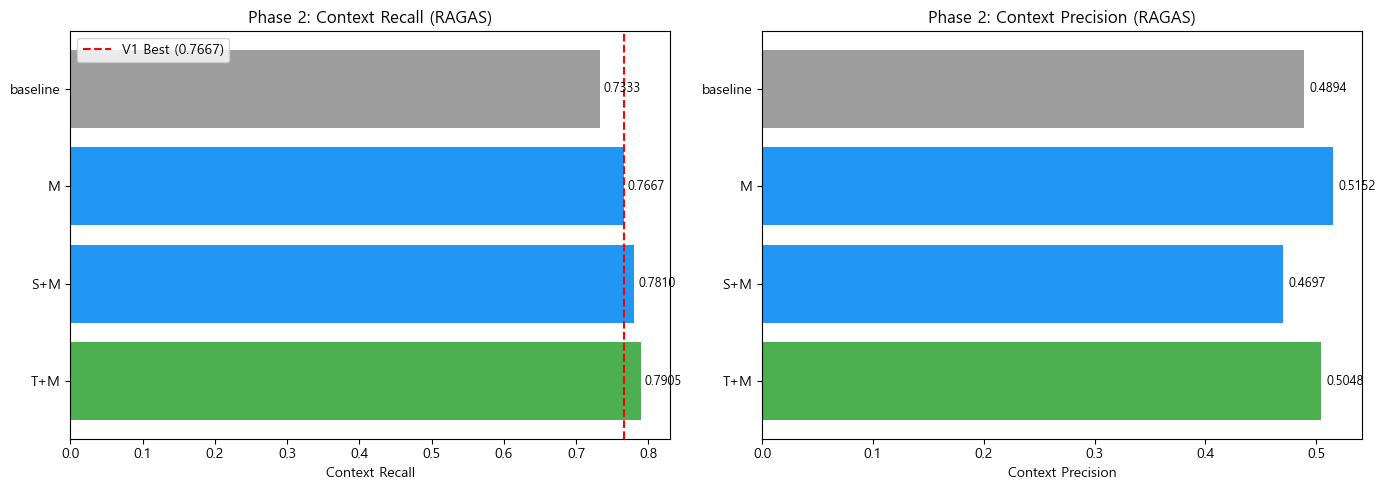

In [13]:
# Phase 2 결과 정리 & 시각화
phase2_df = pd.DataFrame(phase2_results)
phase2_df = phase2_df.sort_values('context_recall', ascending=False).reset_index(drop=True)

print("=== Phase 2: RAGAS Evaluation Results ===")
print(phase2_df[['config', 'label', 'keyword_hr', 'context_recall', 'context_precision', 'num_chunks']].to_string(index=False))

# V1 대비 개선율
best_row = phase2_df.iloc[0]
improvement = best_row['context_recall'] - v1_recall

print(f"\n--- V1 vs V2 ---")
print(f"V1 Best (EXP02): Context Recall = {v1_recall:.4f}")
print(f"V2 Best ({best_row['config']}): Context Recall = {best_row['context_recall']:.4f}")
print(f"Improvement: {'+' if improvement >= 0 else ''}{improvement:.4f} ({improvement/v1_recall*100:+.1f}%)")

# 차트: V1 vs V2 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Context Recall 비교
configs = phase2_df['config'].tolist()
recalls = phase2_df['context_recall'].tolist()
bar_colors = ['#4CAF50' if c == best_row['config'] 
              else '#9E9E9E' if c == 'baseline'
              else '#2196F3' for c in configs]

axes[0].barh(configs, recalls, color=bar_colors)
axes[0].axvline(x=v1_recall, color='red', linestyle='--', label=f'V1 Best ({v1_recall:.4f})')
axes[0].set_xlabel('Context Recall')
axes[0].set_title('Phase 2: Context Recall (RAGAS)')
axes[0].legend()
for i, v in enumerate(recalls):
    axes[0].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=9)

# Context Precision 비교
precisions = phase2_df['context_precision'].tolist()
axes[1].barh(configs, precisions, color=bar_colors)
axes[1].set_xlabel('Context Precision')
axes[1].set_title('Phase 2: Context Precision (RAGAS)')
for i, v in enumerate(precisions):
    if not np.isnan(v):
        axes[1].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../data/experiments/exp01v2_phase2_chart.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# ============================================================
# 7. 결과 저장
# ============================================================

# JSON report
report = {
    "meta": {
        "experiment": "Exp-01-v2 Structure-aware Chunking",
        "version": "v2",
        "date": datetime.now().isoformat(),
        "sample_file": SAMPLE_PDF,
        "num_test_cases": len(golden_df),
        "fixed_params": {
            "alpha": ALPHA,
            "top_k": TOP_K,
            "chunk_size": CHUNK_SIZE,
            "table_strategy": "layout",
        },
        "v1_baseline": {
            "context_recall": v1_recall,
        }
    },
    "best_config": {
        "config": best_row['config'],
        "context_recall": best_row['context_recall'],
        "context_precision": best_row['context_precision'],
        "keyword_hit_rate": best_row['keyword_hr'],
        "improvement_over_v1": improvement,
    },
    "phase1_results": [{
        "config": r['config'],
        "label": r['label'],
        "S": r['S'], "T": r['T'], "M": r['M'],
        "num_chunks": r['num_chunks'],
        "keyword_hit_rate": r['keyword_hit_rate'],
    } for r in phase1_results],
    "phase2_results": [{
        "config": r['config'],
        "label": r['label'],
        "keyword_hr": r['keyword_hr'],
        "context_recall": float(r['context_recall']) if not np.isnan(r['context_recall']) else None,
        "context_precision": float(r['context_precision']) if not np.isnan(r['context_precision']) else None,
        "num_chunks": r['num_chunks'],
        "ragas_time": r['ragas_time'],
    } for r in phase2_results],
}

report_path = "../data/experiments/exp01v2_report.json"
with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(report, f, ensure_ascii=False, indent=2, default=str)
print(f"Report saved: {report_path}")

# CSV (Phase 1 full + Phase 2 merged)
csv_df = phase1_df.copy()
# Phase 2 결과 merge
p2_map = {r['config']: r for r in phase2_results}
csv_df['Context_Recall'] = csv_df['Config'].map(
    lambda c: p2_map[c]['context_recall'] if c in p2_map else None
)
csv_df['Context_Precision'] = csv_df['Config'].map(
    lambda c: p2_map[c]['context_precision'] if c in p2_map else None
)

csv_path = "../data/experiments/exp01v2_results.csv"
csv_df.to_csv(csv_path, index=False)
print(f"CSV saved: {csv_path}")

Report saved: ../data/experiments/exp01v2_report.json
CSV saved: ../data/experiments/exp01v2_results.csv


## 8. 결론

### 실험 결과 요약

- **V2 Best Config**: `T+M` (Table Integration + Metadata)
- **Context Recall**: `0.7905` (V1 best `0.7667` 대비 **+0.0238p, +3.1%**)
- **Context Precision**: `0.5048`
- **Keyword Hit Rate**: `0.8271`

| Config | Keyword HR | Context Recall | Context Precision | vs V1 Best(0.7667) |
|--------|------------|----------------|-------------------|---------------------|
| T+M | 0.8271 | **0.7905** | 0.5048 | **+0.0238** |
| S+M | **0.8381** | 0.7810 | 0.4697 | +0.0143 |
| M | 0.8202 | 0.7667 | **0.5152** | +0.0000 |
| baseline | 0.8096 | 0.7333 | 0.4894 | -0.0333 |

### 핵심 발견

1. **Metadata Enrichment(M)**는 단독으로도 안정적인 개선 레버였습니다.
   - baseline 대비 Keyword HR/Recall 모두 개선되었고, Precision도 가장 높게 관측되었습니다.
2. **Table Integration(T)**는 `M`과 결합될 때(`T+M`) Recall 개선에 가장 크게 기여했습니다.
3. **Structure-aware(S)**는 `M`과 결합 시(`S+M`) Keyword HR 최고점을 만들었지만, Recall은 `T+M`보다 낮았습니다.
4. **전체 결합(S+T+M)**은 기대와 달리 성능이 하락했습니다.
   - 청크 수 증가(1070)로 노이즈가 늘어나 상위 후보에서 제외된 것으로 해석됩니다.

### S+T+M 실행 여부 정리

- `S+T+M`은 코드에 포함되어 있고(**EXPERIMENT_CONFIGS 8개 중 1개**), **Phase 1에서 실제 실행됨**.
- 다만 Phase 2는 Phase 1 상위 설정 + baseline만 평가하도록 설계되어, `S+T+M`은 후보에서 제외되어 RAGAS를 수행하지 않았습니다.

### 최종 선정

- **채택 후보(Exp01-v2)**: `T+M`
- **선정 근거**: V1 대비 Recall 최대 개선(+0.0238) + Precision 0.50 이상 유지

### 다음 단계

1. `T+M`을 Exp02-v2의 고정 청킹/메타데이터 설정으로 승격
2. Exp02-v2에서 Hybrid 결합/Top-K/Reranker를 재탐색
3. 일반화 실험(Exp04)에서 문서 유형이 다른 PDF 2~3개로 재검증

